# BGS Exposure Time Model

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import astropy.table
import astropy.constants
import astropy.units as u
import astropy.io.fits as fits

## BGS Threshold Sample

Load a sample of "threshold" targets provided by @moustakas (see [here](https://github.com/desihub/desisim/pull/285) for details).  This section is intended to be run at nersc and (indirectly) requires that GalSim is installed.

In [ ]:
import astropy.cosmology
import speclite.filters
import specsim.simulator

In [6]:
def load_refspec(
    name='/global/project/projectdirs/desi/spectro/sim/bgs-refspec/bgs-refspec-v1.0.fits',
    save=None):
    hdus = fits.open('bgs-refspec-v1.0.fits', memmap=False)
    wlen = hdus[0].data
    wlen_unit = u.Unit(hdus[0].header['BUNIT'])
    flux = flux = hdus[1].data
    flux_unit = u.Unit(hdus[1].header['BUNIT'])
    meta = astropy.table.Table.read(hdus, hdu=2)
    z_bgs_ref = meta['REDSHIFT']
    hdus.close()
    # Plot the sample.
    r = 22.5 - 2.5 * np.log10(meta['FLUX_R'])
    fix, ax = plt.subplots(1, 2, figsize=(9, 4))
    _, zbins, _ = ax[0].hist(z_bgs_ref, bins=50, histtype='stepfilled', color='lightblue')
    ax[0].set_xlabel('Redshift')
    _, rbins, _ = ax[1].hist(r, bins=50, histtype='stepfilled', color='lightblue')
    ax[1].set_xlabel('r mag')
    plt.tight_layout()
    if save:
        plt.savefig(save)
    return wlen, wlen_unit, flux, flux_unit, meta, z_bgs_ref

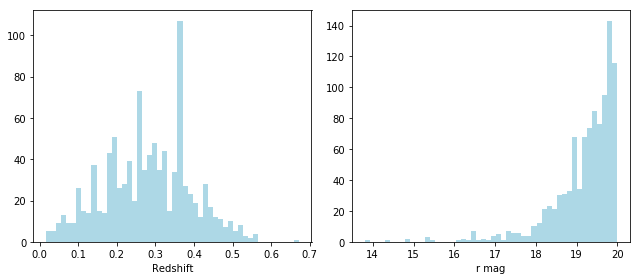

In [7]:
wlen, wlen_unit, flux, flux_unit, meta, z_bgs_ref = load_refspec(save='refspec.png')

Define the nominal BGS shape parameters from the SDSS/Main sample with $\langle z \rangle = 0.1$. For details see [this PR](https://github.com/desihub/desisim/pull/261) and [this notebook](https://github.com/desihub/desitarget/blob/master/doc/nb/bgs-morphology-properties.ipynb).

In [8]:
bulge_fraction = 0.48
bulge_half_light_radius = 1.3 # arcsec
disk_half_light_radius = 4.7  # arcsec
bulge_sersic_n = 2.7

Define a background cosmology for calculating angular size vs redshift:

In [9]:
LCDM = astropy.cosmology.Planck15

Define the band for normalizing the threshold sample:

In [10]:
rband = speclite.filters.load_filter('decam2014-r')

Initialize simulations with the specsim package:

In [11]:
desi = specsim.simulator.Simulator('desi', num_fibers=len(meta))

Use GalSim for slow and accurate fiberloss calculations:

In [12]:
desi.instrument.fiberloss_method = 'galsim'

Use the nominal seeing:

In [13]:
desi.atmosphere.seeing_fwhm_ref = 1.1 * u.arcsec

Use the nominal BRIGHT exposure time at nominal conditions:

In [18]:
desi.observation.exposure_time = 300 * u.s

Prepare simulation parameters:

In [16]:
def prepare_sample(rmag=19.5):
    n = len(meta)
    print('median z =', np.median(z_bgs_ref))
    wave_out = desi.simulated['wavelength'].to(u.Angstrom).value
    # Initialize specsim arrays.
    source_fluxes = np.empty((n, len(wave_out)))
    source_half_light_radius = np.empty((n, 2))
    source_fraction = np.empty((n, 2))
    source_fraction[:, 0] = 1 - bulge_fraction
    source_fraction[:, 1] = bulge_fraction
    # Use a fixed ellipticity.
    source_minor_major_axis_ratio = 0.8 * np.ones((n, 2), float)
    # Assign random position angles, but keep bulge and disk aligned.
    source_position_angle = np.empty((n, 2))
    source_position_angle[:] = np.random.uniform(0., 360., size=n)[:, np.newaxis]
    # Precompute cosmology scale factors.
    angscale = (
        LCDM.angular_diameter_distance(0.1) /
        LCDM.angular_diameter_distance(z_bgs_ref)).to(1).value
    print('median n(z) DA(0.1)/DA(z) =', np.median(angscale))
    
    for i, z in enumerate(z_bgs_ref):
        # Rescale fluxes to the target DECam-r magnitude.
        r_before = rband.get_ab_magnitude(flux[i] * flux_unit, wlen * u.Angstrom)
        rescaled_flux = flux[i] * 10 ** (-0.4 * (rmag - r_before))
        # Interpolate flux to the output wavelength grid.
        source_fluxes[i] = np.interp(wave_out, wlen, rescaled_flux)
        # Calculate the galaxy angular size at this redshift.
        source_half_light_radius[i, 0] = disk_half_light_radius * angscale[i]
        source_half_light_radius[i, 1] = bulge_half_light_radius * angscale[i]
        
    # Return simulation parameters.
    return dict(
        source_fluxes=source_fluxes * flux_unit,
        source_fraction=source_fraction,
        source_half_light_radius=source_half_light_radius,
        source_minor_major_axis_ratio=source_minor_major_axis_ratio,
        source_position_angle=source_position_angle
    )

simargs = prepare_sample()

median z = 0.28671
median n(z) DA(0.1)/DA(z) = 0.427863561743


Simulate once using GalSim to calculate accurate fiberloss fractions (which depend on seeing but not the exposure time or moon/twilight parameters) that we can reuse for faster simulations, as well as the nominal SNR values.

In [19]:
%time desi.simulate(**simargs)

CPU times: user 4min 23s, sys: 23.5 s, total: 4min 47s
Wall time: 4min 47s


Save simulation arrays for quick simulation independent of GalSim. The `etcstudy` script needs this file.

In [22]:
def save_simargs(name):
    table = astropy.table.Table(meta=dict(
        texp=desi.observation.exposure_time.to(u.s).value,
        seeing=desi.atmosphere.seeing_fwhm_ref.to(u.arcsec).value,
    ))
    table['z'] = meta['REDSHIFT']
    table['source_fluxes'] = desi.simulated['source_flux'].transpose()
    table['fiber_acceptance_fraction'] = desi.simulated['fiberloss'].transpose()
    table.write(name, overwrite=True)

In [23]:
save_simargs('bgs_simargs.fits')

Save the simulation results in each camera under nominal conditions. The `etcstudy` script also needs these files.

In [25]:
def save_nominal(basename):
    for i, band in enumerate(desi.camera_names):
        desi.camera_output[i].write('{}_{}.fits'.format(basename, band), overwrite=True)

In [26]:
save_nominal('bgs_nominal')

Plot the fiberloss fractions for the threshold sample:

slice at 6700.0A has median 0.204


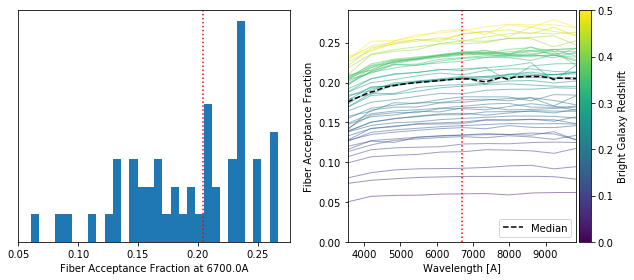

In [18]:
def plot_fiberloss(nplot=100):
    wlen = desi.simulated['wavelength'].to(u.Angstrom).value
    floss = desi.simulated['fiberloss'].transpose()
    floss_med = np.median(floss, axis=0)

    fig, ax = plt.subplots(1, 2, figsize=(9, 4))
    
    norm = matplotlib.colors.Normalize(vmin=0.0, vmax=0.5)
    sm = matplotlib.cm.ScalarMappable(norm=norm, cmap=plt.get_cmap('viridis'))
    for i, z in enumerate(meta['REDSHIFT'][:nplot]):
        ax[1].plot(wlen, floss[i], alpha=0.5, ls='-', lw=1,
                 color=sm.to_rgba(z))
    ax[1].plot(wlen, floss_med, 'k--', label='Median')
    ax[1].legend(loc='lower right')
    sm._A = []
    plt.colorbar(sm, ax=ax[1], pad=0.01).set_label('Bright Galaxy Redshift')
    ax[1].set_xlabel('Wavelength [A]')
    ax[1].set_ylabel('Fiber Acceptance Fraction')
    ax[1].set_xlim(wlen[0], wlen[-1])
    ax[1].set_ylim(0, None)
    
    idx = len(wlen) // 2
    wlen0 = wlen[idx]
    med0 = np.median(floss[:, idx])
    print('slice at {:.1f}A has median {:.3f}'.format(wlen0, med0))
    ax[1].axvline(wlen0, ls=':', c='r')
    ax[0].hist(floss[:, idx], bins=30)
    ax[0].axvline(med0, ls=':', c='r')
    ax[0].set_xlabel('Fiber Acceptance Fraction at {:.1f}A'.format(wlen0))
    ax[0].set_yticks([])
    plt.tight_layout()
    
plot_fiberloss()
plt.savefig('bgs_fiberloss.png')

The next step is to run `etcstudy` to calculate SNR over a realistic set of observing conditions, e.g.
```
export DESISURVEY_OUTPUT=/global/projecta/projectdirs/desi/datachallenge/surveysim2017/depth_0m
etcstudy --verbose --seed 1 --texp 300 --simpar bgs_simargs.fits --nominal bgs_nominal --progress progress.fits --ncond 1000 --output bgs_1.fits --nosun > bgs_1.log &
etcstudy --verbose --seed 2 --texp 300 --simpar bgs_simargs.fits --nominal bgs_nominal --progress progress.fits --ncond 1000 --output bgs_2.fits --nosun > bgs_2.log &
etcstudy --verbose --seed 3 --texp 300 --simpar bgs_simargs.fits --nominal bgs_nominal --progress progress.fits --ncond 1000 --output bgs_3.fits --nomoon > bgs_3.log &
```

## Model Building

This section requires the `sklearn` and `corner` packages and reads the `etcstudy` output (but does not need to be run at nersc).

In [62]:
import scipy.optimize

In [3]:
import sklearn.linear_model
import corner

In [4]:
def load_etcstudy(seeds, name='../../../work/bgs_{}.fits'):
    tables = []
    for seed in seeds:
        tables.append(astropy.table.Table.read(name.format(seed)))
    table = astropy.table.vstack(tables)
    print('Loaded {} rows from {} files.'.format(len(table), len(seeds)))
    table['tratio05'] = table['tratio'][:, 0]
    table['tratio50'] = table['tratio'][:, 1]
    table['tratio95'] = table['tratio'][:, 2]
    table.remove_column('tratio')
    return table

In [5]:
def plot_conditions(study):
    fields = []
    if np.std(study['airmass']) > 0:
        fields.append('airmass')
    if np.any(study['moonv'] > 0):
        fields.extend(['moonalt', 'moonfrac', 'moonsep', 'moonv'])
    if np.any(study['sunr'] > 0):
        fields.extend(['sunalt', 'sundaz', 'sunr'])
    fields.append('tratio50')
    print('plotting', fields)
    data = np.array(study[fields])
    flat = data.view((np.float, len(data.dtype.names)))
    corner.corner(flat, labels=data.dtype.names)

```
etcstudy --verbose --seed 4 --texp 300 --simpar bgs_simargs.fits --nominal bgs_nominal --progress $PWD/progress.fits --ncond 1000 --nomoon --nosun --output bgs_4.fits
```

In [55]:
airmass_study = load_etcstudy((4,))

Loaded 1000 rows from 1 files.


plotting ['airmass', 'tratio50']


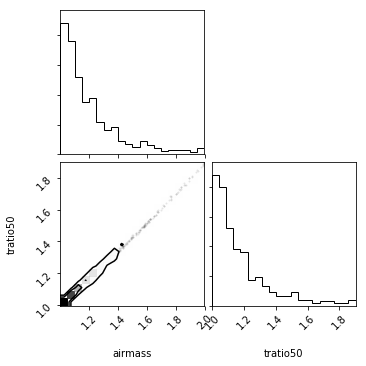

In [56]:
plot_conditions(airmass_study)

In [70]:
def fit_airmass(study, save=None):
    
    airmass = np.array(study['airmass'])
    tratio50 = np.array(study['tratio50'])
    
    def model(p, x):
        a, alpha = p
        return a + (1 - a) * x ** alpha
    
    def residual(p, x, y):
        return model(p, x) - y

    pars = [1., 1.]
    fit = scipy.optimize.least_squares(residual, pars, args=(airmass, tratio50))
    print(fit.x)
    x_model = np.linspace(1., 2., 50)
    y_model = model(fit.x, x_model)
    
    y_old = x_model ** 1.25

    plt.plot(airmass, tratio50, '.')
    plt.plot(x_model, y_model, '-')
    plt.plot(x_model, y_old, 'r--')
    
    plt.xlabel('Airmass')
    plt.ylabel('Exposure time correction')
    plt.xlim(x_model[0], x_model[-1])
    plt.grid()
    plt.tight_layout()
    if save:
        plt.savefig(save)

[ 0.33572647  1.22829039]


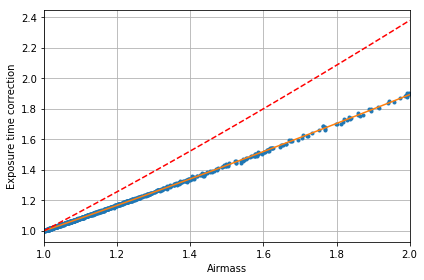

In [72]:
fit_airmass(airmass_study, save='airmass.png')

Define an airmass model to divide out of the moon-up and twilight exposure time corrections below:

In [76]:
def airmass_corrected(X, tratio):
    a, alpha = 0.33572647, 1.22829039
    return tratio / (a + (1 - a) * X ** alpha)

```
etcstudy --verbose --seed 1 --texp 300 --simpar bgs_simargs.fits --nominal bgs_nominal --progress $PWD/progress.fits --ncond 1000 --nosun --output bgs_1.fits
```

In [73]:
moon_study = load_etcstudy((1,))

Loaded 1000 rows from 1 files.


plotting ['airmass', 'moonalt', 'moonfrac', 'moonsep', 'moonv', 'tratio50']


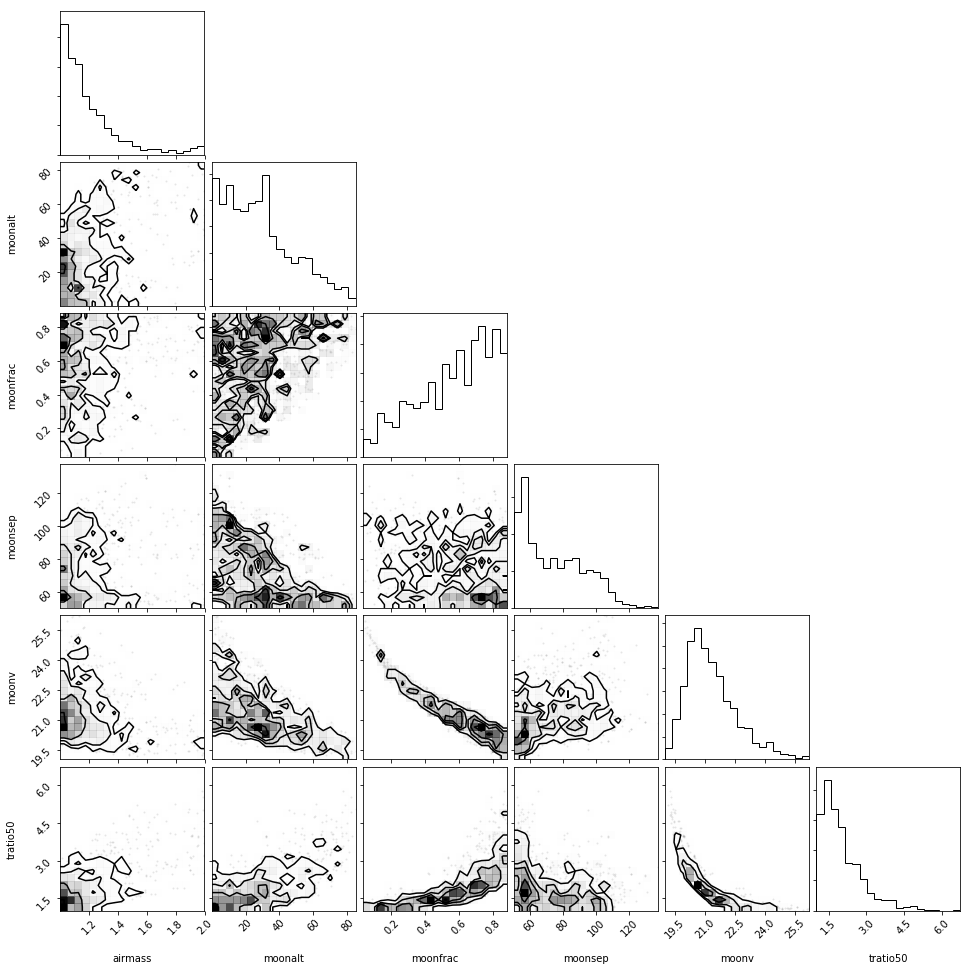

In [100]:
plot_conditions(moon_study)

In [85]:
def fit_moon(study, save=None):
    
    airmass = np.array(study['airmass'])
    moonv = np.array(study['moonv'])
    tratio50 = airmass_corrected(airmass, np.array(study['tratio50']))
    
    model = sklearn.linear_model.LinearRegression(fit_intercept=False)
    getX = lambda x: np.vstack((1 + 0*x, np.exp(-x),1/x, 1/x**2, 1/x**3)).transpose()
    model.fit(getX(moonv), tratio50)
    print(list(model.coef_))
    x_model = np.linspace(np.min(moonv) - 0.2, np.max(moonv) + 0.2, 50)
    y_model = model.predict(getX(x_model))

    plt.scatter(moonv, tratio50, c=airmass, s=5)
    plt.colorbar().set_label('Airmass')
    plt.plot(x_model, y_model, 'r-')
    
    plt.axhline(1., ls=':', c='r')
    plt.xlabel('Scattered moon V-band magnitude')
    plt.ylabel('Exposure time correction')
    plt.xlim(x_model[0], x_model[-1])
    plt.grid()
    plt.tight_layout()
    if save:
        plt.savefig(save)

In [92]:
def lmfit_moon(study, save=None):
    
    airmass = np.array(study['airmass'])
    moonv = np.array(study['moonv'])
    tratio50 = airmass_corrected(airmass, np.array(study['tratio50']))

    #mmax = 26.5
    
    def model(p, x):
        a, b, c, d, e = p
        return a + b * np.exp(-x) + c / x + d / x ** 2 + e / x ** 3
    
    def residual(p, x, y):
        return model(p, x) - y

    pars = [-127.9857669887616, -91667639.794329479, 9437.9591340794886, -230425.87186532648, 1877787.1581087618]
    #fit = scipy.optimize.least_squares(residual, pars, args=(airmass, tratio50))
    #print(list(fit.x))
    x_model = np.linspace(np.min(moonv) - 0.2, np.max(moonv) + 0.2, 50)
    #y_model = model(fit.x, x_model)
    y_model = model(pars, x_model)

    plt.scatter(moonv, tratio50, c=airmass, s=5)
    plt.colorbar().set_label('Airmass')
    plt.plot(x_model, y_model, 'r-')
    
    plt.axhline(1., ls=':', c='r')
    plt.xlabel('Scattered moon V-band magnitude')
    plt.ylabel('Exposure time correction')
    plt.xlim(x_model[0], x_model[-1])
    plt.grid()
    plt.tight_layout()
    if save:
        plt.savefig(save)

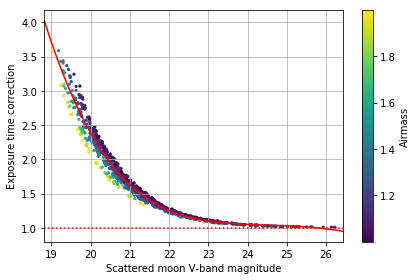

In [93]:
lmfit_moon(moon_study)

[-127.9857669887616, -91667639.794329479, 9437.9591340794886, -230425.87186532648, 1877787.1581087618]


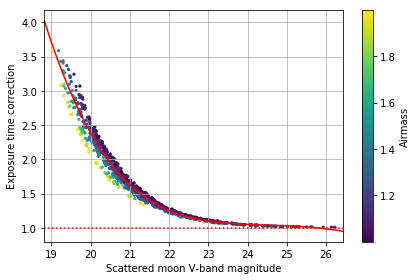

In [82]:
fit_moon(moon_study)

```
etcstudy --verbose --seed 3 --texp 300 --simpar bgs_simargs.fits --nominal bgs_nominal --progress $PWD/progress.fits --ncond 1000 --nomoon --output bgs_3.fits
```

In [49]:
sun_study = load_etcstudy(seeds=(3,))

Loaded 1000 rows from 1 files.


plotting ['airmass', 'sunalt', 'sundaz', 'sunr', 'tratio50']


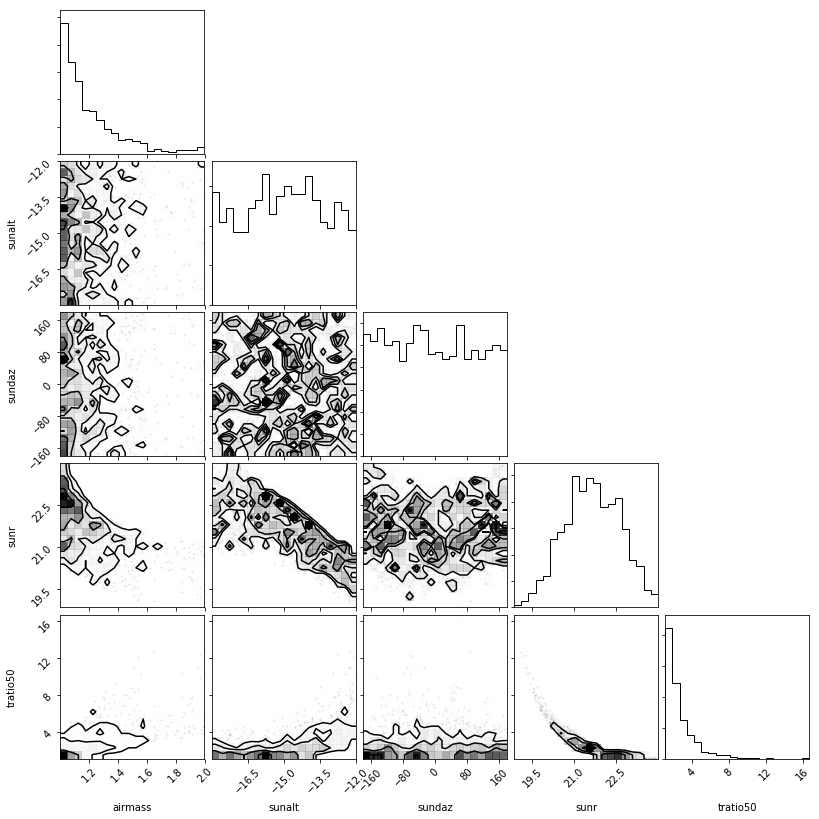

In [99]:
plot_conditions(sun_study)

In [97]:
def fit_sun(study, save=None):
    
    airmass = np.array(study['airmass'])
    sunr = np.array(study['sunr'])
    tratio50 = airmass_corrected(airmass, np.array(study['tratio50']))
    
    model = sklearn.linear_model.LinearRegression(fit_intercept=False)
    getX = lambda x: np.vstack((1 + 0*x, np.exp(-x),1/x, 1/x**2, 1/x**3)).transpose()
    model.fit(getX(sunr), tratio50)
    print(list(model.coef_))
    x_model = np.linspace(np.min(sunr) - 0.2, np.max(sunr) + 0.2, 50)
    y_model = model.predict(getX(x_model))

    plt.scatter(sunr, tratio50, c=airmass, s=5)
    plt.colorbar().set_label('Airmass')
    plt.plot(x_model, y_model, 'r-')
    
    plt.axhline(1., ls=':', c='r')
    plt.xlabel('Scattered twilight r-band magnitude')
    plt.ylabel('Exposure time correction')
    plt.xlim(x_model[0], x_model[-1])
    plt.grid()
    plt.tight_layout()
    if save:
        plt.savefig(save)

[-667.93716373233099, -363559554.14350104, 46658.045539215556, -1087152.5550806229, 8464738.4692266732]


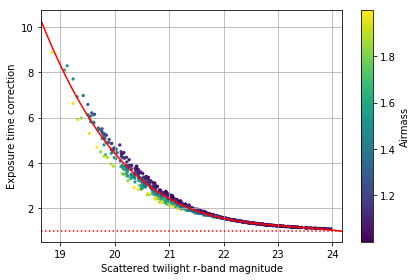

In [98]:
fit_sun(sun_study)